In [1]:
import os
import pandas as pd
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, transforms
import matplotlib.pyplot as plt

In [2]:
plt.rcdefaults()

In [3]:
# Plotting function

def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [4]:
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"

def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

class SpectrogramDataset(Dataset):
    def __init__(self, data_path, file_ext, window_size, transform=None):
        # data loading
        self.data_path = data_path
        self.file_ext = file_ext
        self.window_size = window_size
        self.transform = transform

        # Obtain all shot numbers
        self.all_shots = [int(os.path.basename(x.split(f".{file_ext}")[0]))
                          for x in glob.glob(os.path.join(data_path, f"*.{file_ext}"))]

    def __len__(self):
        return len(self.all_shots)

    def __getitem__(self, idx):
        shotno = self.all_shots[idx]

        # Load data for the experiment
        data_shot = load_shot(shotno, self.data_path, self.file_ext)

        # Extract inputs
        inputs = data_shot["x"]["spectrogram"]
        spec_even = inputs["EvenN"]
        spec_odd = inputs["OddN"]
        f = inputs["frequency"]
        t = inputs["time"]

        # Calculate the number of windows based on window size
        num_windows = spec_even.shape[1] // self.window_size

        # Extract windows along with their start and end indices
        windows = []
        for i in range(num_windows):
            start_idx = i * self.window_size
            end_idx = start_idx + self.window_size

            window_even = spec_even[:, start_idx:end_idx]
            window_odd = spec_odd[:, start_idx:end_idx]

            if self.transform:
                window_even = self.transform(window_even)
                window_odd = self.transform(window_odd)

            windows.append({
                'window_even': window_even,
                'window_odd': window_odd,
                'frequency': f,
                'time': t[start_idx:end_idx],
                'start_idx': start_idx,
                'end_idx': end_idx,
                'shotno': shotno
            })

        return windows

# Example usage:
# Define hyperparameters
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"
window_size = 64  # Length of the window
batch_size = 32  # Number of windows

# Create dataset and dataloader
#transform = transforms.Compose([
    # Add any additional transformations you need
#])

dataset = SpectrogramDataset(DATA_PATH, FILE_EXT, window_size, transform=None)
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
first_data = dataset[93][31] # First item of the first batch of 32 windows (which all correspond to a SINGLE shotno)
# First number is the shotno, the second one is which window we are accessing for that shotno.

for key, item in first_data.items():
    if isinstance(item, (list, np.ndarray, torch.Tensor)):
        if isinstance(item, (np.ndarray, torch.Tensor)):
            print(key, item.shape)
        else:
            print(key, len(item))
    elif isinstance(item, int):
        print(key, item)

window_even (2280, 64)
window_odd (2280, 64)
frequency (2049,)
time (64,)
start_idx 1984
end_idx 2048
shotno 73023


Experiment number: 73018, and window number: 8


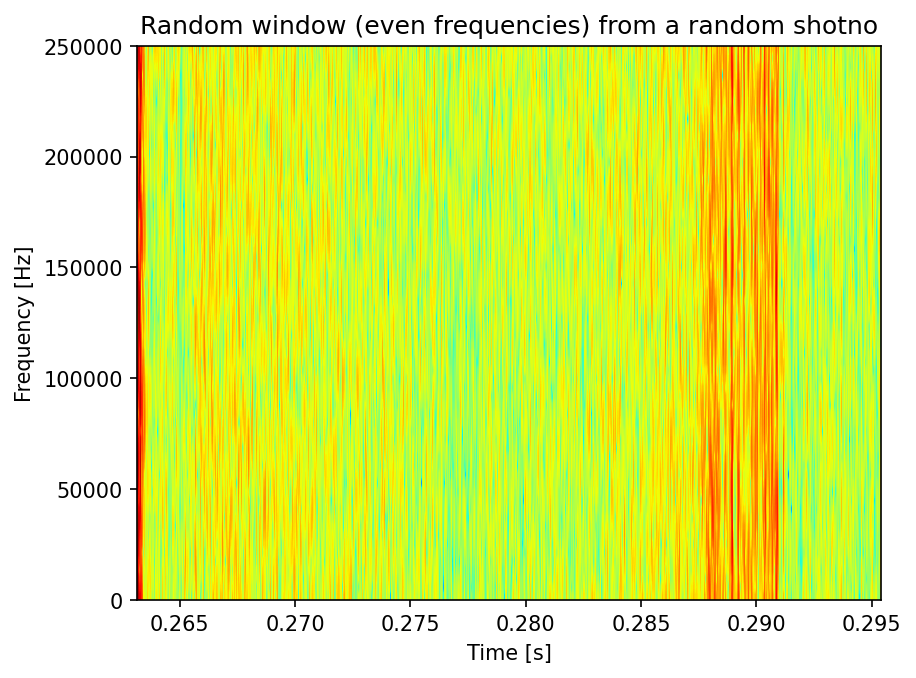

In [6]:
idx_shotno = np.random.randint(1,94) # Choose a random experiment
idx_windowno = np.random.randint(1,batch_size)
# Plot a random window (even frequencies) from a random shotno
random_sample = dataset[idx_shotno][idx_windowno]
print(f"Experiment number: {random_sample['shotno']}, and window number: {idx_windowno}")

plot_spectrogram(random_sample["window_even"], title = "Random window (even frequencies) from a random shotno",\
                time = random_sample["time"], frequency = random_sample["frequency"])

### Let's verify that this is correct using the real data

In [7]:
data_shot = load_shot(random_sample['shotno'], DATA_PATH, FILE_EXT)

# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]

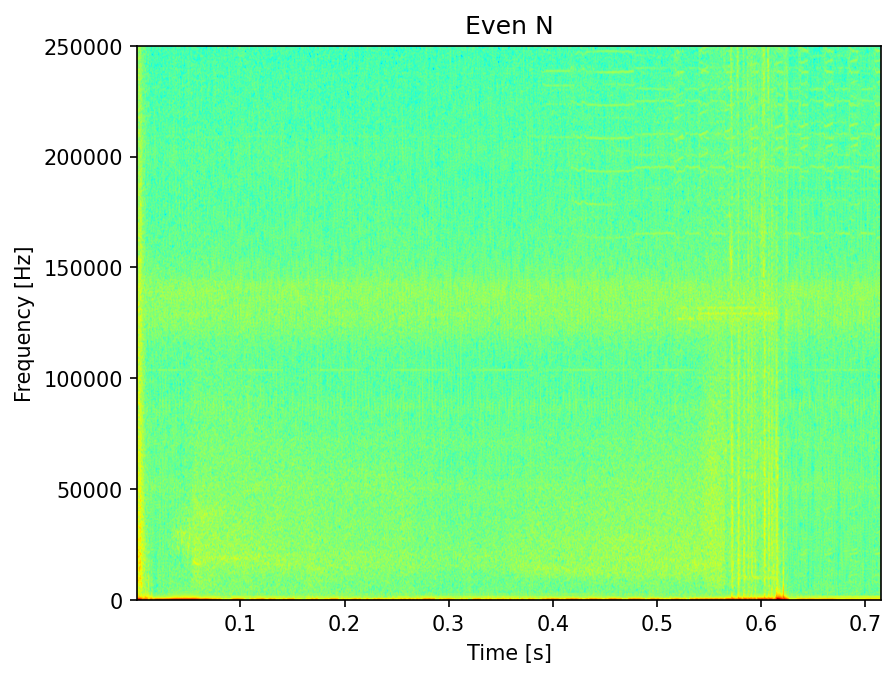

In [8]:
plot_spectrogram(spec_even, "Even N", t, f)